Random Forest Test Accuracy: 0.7775
Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.93      0.91        88
         Low       0.76      0.88      0.81       182
      Medium       0.71      0.53      0.61       130

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.77      0.78      0.77       400

Confusion Matrix:
[[ 82   0   6]
 [  0 160  22]
 [ 10  51  69]]


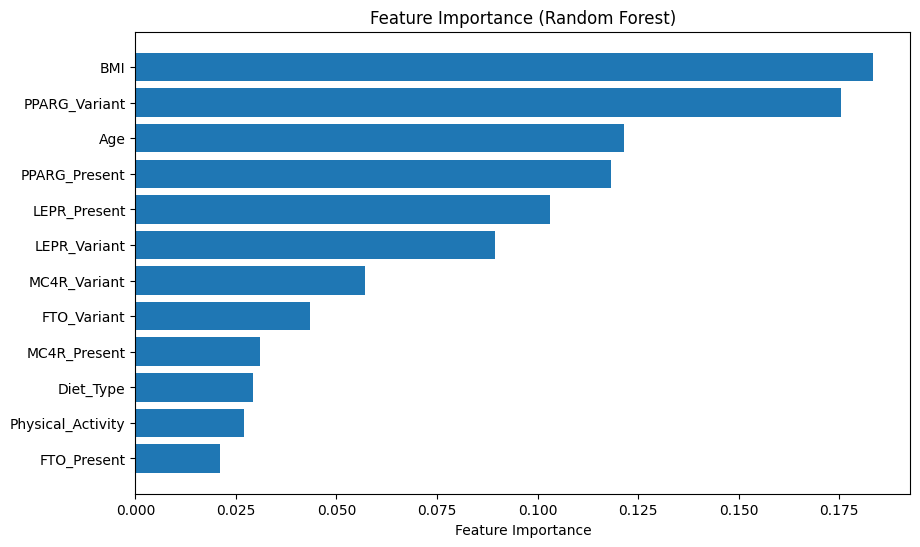

ValueError: target must be specified for multi-class

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import random  # For introducing randomness in recommendations
import os  # To set environment variables
import matplotlib.pyplot as plt

# Set the number of CPUs for joblib (optional)
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

#############################
# Random Forest Obesity Risk Prediction
#############################

# Load genetic dataset (assumes comma-delimited)
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Convert Obesity_Risk_Score into categories (Low, Medium, High)
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Initialize dictionary to store LabelEncoders
label_encoders = {}

# Encode categorical variables (Diet_Type, Physical_Activity)
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns as strings (so that "None" is encoded too)
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features and target for the genetic model
features = [
    "Age", "BMI", "Physical_Activity", "Diet_Type",
    "MC4R_Present", "MC4R_Variant",
    "PPARG_Present", "PPARG_Variant",
    "FTO_Present", "FTO_Variant",
    "LEPR_Present", "LEPR_Variant"
]
target = "Obesity_Risk_Category"

X_gen = genetic_df[features]
y_gen = genetic_df[target]

# Encode target labels (Low, Medium, High)
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y_gen)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_encoded, test_size=0.2, random_state=42)

# Scale features (important for Random Forest and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

#############################
# 1. Feature Importance using Random Forest
#############################

# Get feature importance from Random Forest
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx_rf = feature_importances.argsort()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx_rf], feature_importances[sorted_idx_rf])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Feature Importance")
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_feature_importance.png")
plt.show()

#############################
# 2. Partial Dependence Plots (PDP)
#############################

# Generate PDPs for the top 5 most important features from Random Forest
important_features_rf = [features[i] for i in sorted_idx_rf[:5]]  # Top 5 important features

# Generate PDPs for the selected features (specifying target=None for multi-class)
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train_df,
    features=important_features_rf,
    feature_names=features,
    kind="average",  # 'average' kind to show effect of features
    target=None  # Handle multi-class case by setting target=None
)
display.figure_.suptitle("Partial Dependence Plots for Random Forest Classifier")
plt.subplots_adjust(hspace=0.6)
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_partial_dependence_plots.png")
plt.show()

#############################
# 3. Permutation Importance
#############################

# Calculate permutation importance
perm_importance_rf = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores and their indices
importances_rf = perm_importance_rf.importances_mean
sorted_idx_perm_rf = importances_rf.argsort()

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx_perm_rf], importances_rf[sorted_idx_perm_rf])
plt.title("Permutation Importance (Random Forest)")
plt.xlabel("Mean Decrease in Accuracy")
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_permutation_importance.png")
plt.show()

#############################
# Meal Recommendation (Same as before)
#############################

# Load the meal dataset (assumed to be comma-delimited)
meal_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\train.csv"
meal_df = pd.read_csv(meal_file_path)

# Preprocess nutritional features; these columns should exist in your meal dataset
nutritional_features = meal_df[['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]
scaler_meal = StandardScaler()
nutritional_features_scaled = scaler_meal.fit_transform(nutritional_features)

# Cluster meals using KMeans (e.g., 10 clusters)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
meal_df['Meal_Cluster'] = kmeans.fit_predict(nutritional_features_scaled)

# Define a meal recommendation function that uses the predicted obesity risk category
def recommend_meals(user_profile, meal_df, rf_model, target_le, scaler, num_meals=5):
    """
    user_profile: dict with genetic feature values (original, unencoded)
    rf_model: trained Random Forest model
    target_le: LabelEncoder for the target risk category
    scaler: StandardScaler fitted on genetic features
    """
    # Convert user_profile into a DataFrame
    user_profile_df = pd.DataFrame([user_profile])
    
    # Encode categorical features using stored encoders
    for col in ["Diet_Type", "Physical_Activity"]:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col])
    for col in variant_columns:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col].astype(str))
    
    # Ensure the user profile contains all required features; fill missing with 0
    missing_cols = set(features) - set(user_profile_df.columns)
    for col in missing_cols:
        user_profile_df[col] = 0
    user_profile_df = user_profile_df[features]
    
    # Scale the user profile using the same scaler as training
    user_profile_scaled = scaler.transform(user_profile_df)
    
    # Predict obesity risk using the Random Forest model
    predicted_category = rf_model.predict(user_profile_scaled)[0]
    predicted_label = target_le.inverse_transform([predicted_category])[0]
    print(f"\nPredicted Obesity Risk Category: {predicted_label}")
    
    # Define cluster preferences based on predicted risk (example logic)
    if predicted_label == 'Low':
        preferred_clusters = [0, 1, 2, 3]  # Broaden the cluster selection
        sort_by = random.choice(['Protein_g', 'Energy_kcal'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    elif predicted_label == 'Medium':
        preferred_clusters = [4, 5, 6, 7]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Fat_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    else:
        preferred_clusters = [8, 9, 0, 1]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Carb_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    
    # Filter and sort meals from the preferred clusters
    recommended_meals = meal_df[meal_df['Meal_Cluster'].isin(preferred_clusters)]
    recommended_meals = recommended_meals.sample(frac=1).reset_index(drop=True)  # Shuffle the meals
    recommended_meals = recommended_meals.sort_values(by=sort_by, ascending=ascending)
    
    print("\nRecommended Meals:")
    print(recommended_meals[['Descrip', 'Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']].head(num_meals))

# Example new genetic profile for meal recommendation (using original, unencoded values)
new_profile = {
    "Age": 35,
    "BMI": 28.5,
    "Physical_Activity": "Low",      # Original string (will be encoded)
    "Diet_Type": "High-Fat",           # Original string (will be encoded)
    "MC4R_Present": 0,
    "MC4R_Variant": "rs17782313_TT",
    "PPARG_Present": 0,
    "PPARG_Variant": "rs1801282_CG",
    "FTO_Present": 1,
    "FTO_Variant": "rs9939609_AT",
    "LEPR_Present": 1,
    "LEPR_Variant": "rs1137101_AG"
}

# Get meal recommendations using the Random Forest model
recommend_meals(new_profile, meal_df, rf_model, target_le, scaler, num_meals=5)


Random Forest Test Accuracy: 0.7775
Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.93      0.91        88
         Low       0.76      0.88      0.81       182
      Medium       0.71      0.53      0.61       130

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.77      0.78      0.77       400

Confusion Matrix:
[[ 82   0   6]
 [  0 160  22]
 [ 10  51  69]]


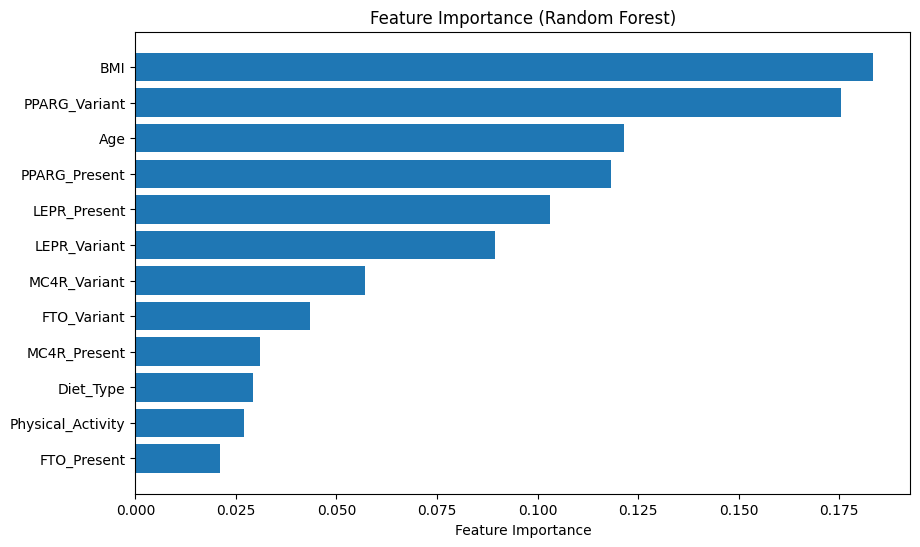

ValueError: target must be specified for multi-class

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import random  # For introducing randomness in recommendations
import os  # To set environment variables
import matplotlib.pyplot as plt

# Set the number of CPUs for joblib (optional)
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

#############################
# Random Forest Obesity Risk Prediction
#############################

# Load genetic dataset (assumes comma-delimited)
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Convert Obesity_Risk_Score into categories (Low, Medium, High)
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Initialize dictionary to store LabelEncoders
label_encoders = {}

# Encode categorical variables (Diet_Type, Physical_Activity)
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns as strings (so that "None" is encoded too)
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features and target for the genetic model
features = [
    "Age", "BMI", "Physical_Activity", "Diet_Type",
    "MC4R_Present", "MC4R_Variant",
    "PPARG_Present", "PPARG_Variant",
    "FTO_Present", "FTO_Variant",
    "LEPR_Present", "LEPR_Variant"
]
target = "Obesity_Risk_Category"

X_gen = genetic_df[features]
y_gen = genetic_df[target]

# Encode target labels (Low, Medium, High)
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y_gen)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_encoded, test_size=0.2, random_state=42)

# Scale features (important for Random Forest and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

#############################
# 1. Feature Importance using Random Forest
#############################

# Get feature importance from Random Forest
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx_rf = feature_importances.argsort()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx_rf], feature_importances[sorted_idx_rf])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Feature Importance")
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_feature_importance.png")
plt.show()

#############################
# 2. Partial Dependence Plots (PDP)
#############################

# Generate PDPs for the top 5 most important features from Random Forest
important_features_rf = [features[i] for i in sorted_idx_rf[:5]]  # Top 5 important features

# Generate PDPs for the selected features (specifying target=None for multi-class)
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train_df,
    features=important_features_rf,
    feature_names=features,
    kind="average",  # 'average' kind to show effect of features
    target=None  # Handle multi-class case by setting target=None
)
display.figure_.suptitle("Partial Dependence Plots for Random Forest Classifier")
plt.subplots_adjust(hspace=0.6)
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_partial_dependence_plots.png")
plt.show()

#############################
# 3. Permutation Importance
#############################

# Calculate permutation importance
perm_importance_rf = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores and their indices
importances_rf = perm_importance_rf.importances_mean
sorted_idx_perm_rf = importances_rf.argsort()

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx_perm_rf], importances_rf[sorted_idx_perm_rf])
plt.title("Permutation Importance (Random Forest)")
plt.xlabel("Mean Decrease in Accuracy")
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_permutation_importance.png")
plt.show()

#############################
# Meal Recommendation (Same as before)
#############################

# Load the meal dataset (assumed to be comma-delimited)
meal_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\train.csv"
meal_df = pd.read_csv(meal_file_path)

# Preprocess nutritional features; these columns should exist in your meal dataset
nutritional_features = meal_df[['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]
scaler_meal = StandardScaler()
nutritional_features_scaled = scaler_meal.fit_transform(nutritional_features)

# Cluster meals using KMeans (e.g., 10 clusters)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
meal_df['Meal_Cluster'] = kmeans.fit_predict(nutritional_features_scaled)

# Define a meal recommendation function that uses the predicted obesity risk category
def recommend_meals(user_profile, meal_df, rf_model, target_le, scaler, num_meals=5):
    """
    user_profile: dict with genetic feature values (original, unencoded)
    rf_model: trained Random Forest model
    target_le: LabelEncoder for the target risk category
    scaler: StandardScaler fitted on genetic features
    """
    # Convert user_profile into a DataFrame
    user_profile_df = pd.DataFrame([user_profile])
    
    # Encode categorical features using stored encoders
    for col in ["Diet_Type", "Physical_Activity"]:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col])
    for col in variant_columns:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col].astype(str))
    
    # Ensure the user profile contains all required features; fill missing with 0
    missing_cols = set(features) - set(user_profile_df.columns)
    for col in missing_cols:
        user_profile_df[col] = 0
    user_profile_df = user_profile_df[features]
    
    # Scale the user profile using the same scaler as training
    user_profile_scaled = scaler.transform(user_profile_df)
    
    # Predict obesity risk using the Random Forest model
    predicted_category = rf_model.predict(user_profile_scaled)[0]
    predicted_label = target_le.inverse_transform([predicted_category])[0]
    print(f"\nPredicted Obesity Risk Category: {predicted_label}")
    
    # Define cluster preferences based on predicted risk (example logic)
    if predicted_label == 'Low':
        preferred_clusters = [0, 1, 2, 3]  # Broaden the cluster selection
        sort_by = random.choice(['Protein_g', 'Energy_kcal'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    elif predicted_label == 'Medium':
        preferred_clusters = [4, 5, 6, 7]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Fat_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    else:
        preferred_clusters = [8, 9, 0, 1]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Carb_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    
    # Filter and sort meals from the preferred clusters
    recommended_meals = meal_df[meal_df['Meal_Cluster'].isin(preferred_clusters)]
    recommended_meals = recommended_meals.sample(frac=1).reset_index(drop=True)  # Shuffle the meals
    recommended_meals = recommended_meals.sort_values(by=sort_by, ascending=ascending)
    
    print("\nRecommended Meals:")
    print(recommended_meals[['Descrip', 'Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']].head(num_meals))

# Example new genetic profile for meal recommendation (using original, unencoded values)
new_profile = {
    "Age": 35,
    "BMI": 28.5,
    "Physical_Activity": "Low",      # Original string (will be encoded)
    "Diet_Type": "High-Fat",           # Original string (will be encoded)
    "MC4R_Present": 0,
    "MC4R_Variant": "rs17782313_TT",
    "PPARG_Present": 0,
    "PPARG_Variant": "rs1801282_CG",
    "FTO_Present": 1,
    "FTO_Variant": "rs9939609_AT",
    "LEPR_Present": 1,
    "LEPR_Variant": "rs1137101_AG"
}

# Get meal recommendations using the Random Forest model
recommend_meals(new_profile, meal_df, rf_model, target_le, scaler, num_meals=5)


In [1]:
import pandas as pd
import numpy as np
import os
import random  # For introducing randomness in recommendations
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress joblib warning about physical cores
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Define an output directory for saving evaluation plots
output_dir = r"C:\Users\trejan\Desktop\GNN\XGB"
os.makedirs(output_dir, exist_ok=True)

#############################
# Pipeline 1: SVM for Obesity Risk Prediction
#############################

# Load genetic dataset (assumes comma-delimited)
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Convert Obesity_Risk_Score into categories (Low, Medium, High)
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Initialize dictionary to store LabelEncoders
label_encoders = {}

# Encode categorical variables (Diet_Type, Physical_Activity)
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns as strings (so that "None" is encoded too)
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features and target for the genetic model
features = [
    "Age", "BMI", "Physical_Activity", "Diet_Type",
    "MC4R_Present", "MC4R_Variant",
    "PPARG_Present", "PPARG_Variant",
    "FTO_Present", "FTO_Variant",
    "LEPR_Present", "LEPR_Variant"
]
target = "Obesity_Risk_Category"

X_gen = genetic_df[features]
y_gen = genetic_df[target]

# Encode target labels (Low, Medium, High)
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y_gen)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_encoded, test_size=0.2, random_state=42)

# Scale features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVM model with RBF kernel (using default decision_function)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_svm = svm_model.predict(X_test_scaled)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=target_le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

##########################################
# Additional Evaluation Metrics and Graphs
##########################################

# For ROC and PR curves we need continuous scores.
# For SVM, use the decision_function output.
if hasattr(svm_model, "decision_function"):
    y_scores = svm_model.decision_function(X_test_scaled)
else:
    # If probability estimates are available, use them instead.
    y_scores = svm_model.predict_proba(X_test_scaled)

# Binarize the test labels for multi-class ROC and Precision-Recall curves
n_classes = len(target_le.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

# 1. ROC Curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust if number of classes is different
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"ROC for {target_le.classes_[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM Model")
plt.legend(loc="lower right")
roc_path = os.path.join(output_dir, "svm_roc_curves.png")
plt.savefig(roc_path)
plt.close()
print(f"ROC curves saved to: {roc_path}")

# 2. Precision-Recall Curves for each class
plt.figure()
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2,
             label=f"PR for {target_le.classes_[i]} (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for SVM Model")
plt.legend(loc="upper right")
pr_path = os.path.join(output_dir, "svm_precision_recall_curves.png")
plt.savefig(pr_path)
plt.close()
print(f"Precision-Recall curves saved to: {pr_path}")

# 3. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM Model")
cm_path = os.path.join(output_dir, "svm_confusion_matrix.png")
plt.savefig(cm_path)
plt.close()
print(f"Confusion Matrix heatmap saved to: {cm_path}")

# 4. Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    svm_model, X_train_scaled, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.title("Learning Curve for SVM Model")
plt.legend(loc="best")
lc_path = os.path.join(output_dir, "svm_learning_curve.png")
plt.savefig(lc_path)
plt.close()
print(f"Learning Curve saved to: {lc_path}")

#############################
# Pipeline 2: Meal Recommendation (Same as Before)
#############################

# Load the meal dataset (assumed to be comma-delimited)
meal_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\train.csv"
meal_df = pd.read_csv(meal_file_path)

# Preprocess nutritional features; these columns should exist in your meal dataset
nutritional_features = meal_df[['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]
scaler_meal = StandardScaler()
nutritional_features_scaled = scaler_meal.fit_transform(nutritional_features)

# Cluster meals using KMeans (e.g., 10 clusters)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
meal_df['Meal_Cluster'] = kmeans.fit_predict(nutritional_features_scaled)

# Define a meal recommendation function that uses the predicted obesity risk category
def recommend_meals(user_profile, meal_df, svm_model, target_le, scaler, num_meals=5):
    """
    user_profile: dict with genetic feature values (original, unencoded)
    svm_model: trained SVM model
    target_le: LabelEncoder for the target risk category
    scaler: StandardScaler fitted on genetic features
    """
    # Convert user_profile into a DataFrame
    user_profile_df = pd.DataFrame([user_profile])
    
    # Encode categorical features using stored encoders
    for col in ["Diet_Type", "Physical_Activity"]:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col])
    for col in variant_columns:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col].astype(str))
    
    # Ensure the user profile contains all required features; fill missing with 0
    missing_cols = set(features) - set(user_profile_df.columns)
    for col in missing_cols:
        user_profile_df[col] = 0
    user_profile_df = user_profile_df[features]
    
    # Scale the user profile using the same scaler as training
    user_profile_scaled = scaler.transform(user_profile_df)
    
    # Predict obesity risk using the SVM model
    predicted_category = svm_model.predict(user_profile_scaled)[0]
    predicted_label = target_le.inverse_transform([predicted_category])[0]
    print(f"\nPredicted Obesity Risk Category: {predicted_label}")
    
    # Define cluster preferences based on predicted risk (example logic)
    if predicted_label == 'Low':
        preferred_clusters = [0, 1, 2, 3]  # Broaden the cluster selection
        sort_by = random.choice(['Protein_g', 'Energy_kcal'])  # Randomize sorting
        ascending = random.choice([True, False])
    elif predicted_label == 'Medium':
        preferred_clusters = [4, 5, 6, 7]
        sort_by = random.choice(['Energy_kcal', 'Fat_g'])
        ascending = random.choice([True, False])
    else:
        preferred_clusters = [8, 9, 0, 1]
        sort_by = random.choice(['Energy_kcal', 'Carb_g'])
        ascending = random.choice([True, False])
    
    # Filter and sort meals from the preferred clusters
    recommended_meals = meal_df[meal_df['Meal_Cluster'].isin(preferred_clusters)]
    recommended_meals = recommended_meals.sample(frac=1).reset_index(drop=True)
    recommended_meals = recommended_meals.sort_values(by=sort_by, ascending=ascending)
    
    print("\nRecommended Meals:")
    print(recommended_meals[['Descrip', 'Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']].head(num_meals))

# Example new genetic profile for meal recommendation (using original, unencoded values)
new_profile = {
    "Age": 35,
    "BMI": 28.5,
    "Physical_Activity": "Low",      # Original string (will be encoded)
    "Diet_Type": "High-Fat",           # Original string (will be encoded)
    "MC4R_Present": 0,
    "MC4R_Variant": "rs17782313_TT",
    "PPARG_Present": 0,
    "PPARG_Variant": "rs1801282_CG",
    "FTO_Present": 1,
    "FTO_Variant": "rs9939609_AT",
    "LEPR_Present": 1,
    "LEPR_Variant": "rs1137101_AG"
}

# Get meal recommendations using the SVM model
recommend_meals(new_profile, meal_df, svm_model, target_le, scaler, num_meals=5)


SVM Test Accuracy: 0.815
Classification Report:
              precision    recall  f1-score   support

        High       0.88      1.00      0.94        88
         Low       0.75      1.00      0.85       182
      Medium       1.00      0.43      0.60       130

    accuracy                           0.81       400
   macro avg       0.88      0.81      0.80       400
weighted avg       0.86      0.81      0.79       400

Confusion Matrix:
[[ 88   0   0]
 [  0 182   0]
 [ 12  62  56]]
ROC curves saved to: C:\Users\trejan\Desktop\GNN\XGB\svm_roc_curves.png
Precision-Recall curves saved to: C:\Users\trejan\Desktop\GNN\XGB\svm_precision_recall_curves.png
Confusion Matrix heatmap saved to: C:\Users\trejan\Desktop\GNN\XGB\svm_confusion_matrix.png
Learning Curve saved to: C:\Users\trejan\Desktop\GNN\XGB\svm_learning_curve.png


C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 


Predicted Obesity Risk Category: Low

Recommended Meals:
                                                Descrip  Energy_kcal  \
1876     Soybeans, mature seeds, roasted, no salt added        471.0   
2003  Pork, cured, bacon, pre-sliced, cooked, pan-fried        468.0   
2152                               Bacon bits, meatless        476.0   
445                                      Cheese, romano        387.0   
1441              Beef, cured, breakfast strips, cooked        449.0   

      Protein_g  Fat_g  Carb_g  
1876      35.22  25.40   33.55  
2003      33.92  35.09    1.70  
2152      32.00  25.90   28.60  
445       31.80  26.94    3.63  
1441      31.30  34.40    1.40  


Random Forest Test Accuracy: 0.7775
Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.93      0.91        88
         Low       0.76      0.88      0.81       182
      Medium       0.71      0.53      0.61       130

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.77      0.78      0.77       400

Confusion Matrix:
[[ 82   0   6]
 [  0 160  22]
 [ 10  51  69]]


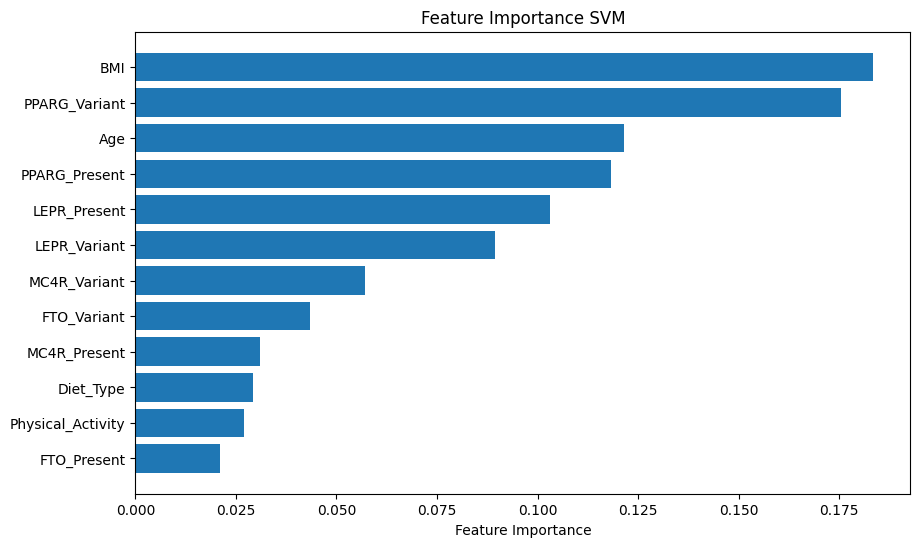

C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X h

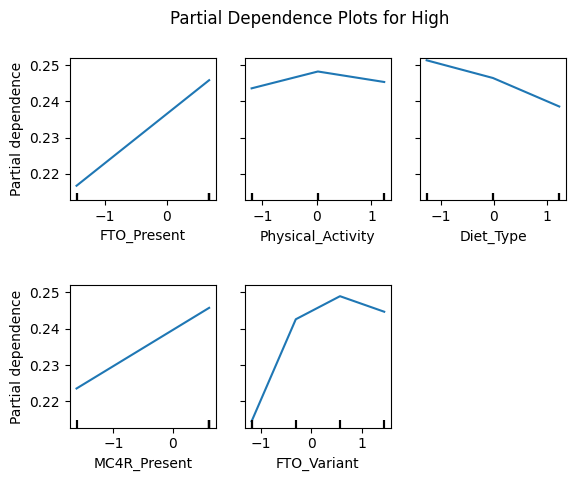

C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X h

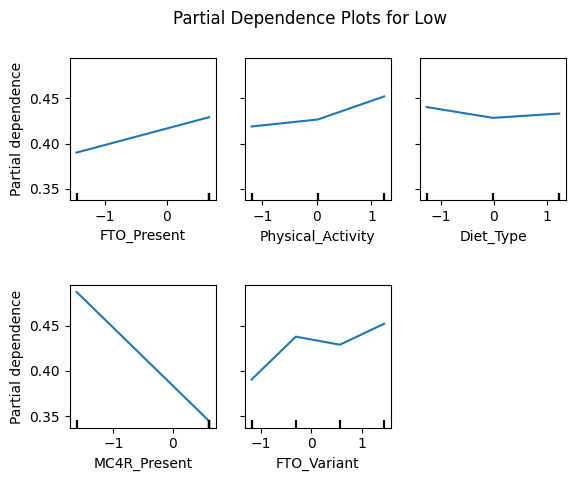

C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\trejan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X h

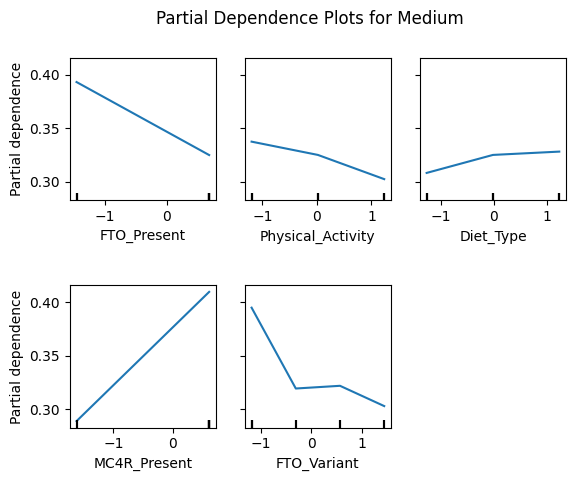

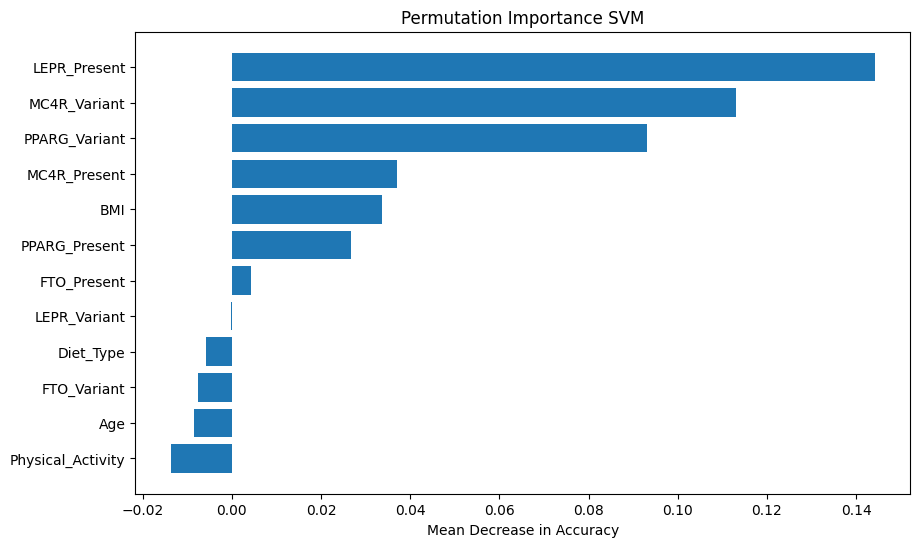

NameError: name 'KMeans' is not defined

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import random  # For introducing randomness in recommendations
import os  # To set environment variables
import matplotlib.pyplot as plt

# Set the number of CPUs for joblib (optional)
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

#############################
# Random Forest Obesity Risk Prediction
#############################

# Load genetic dataset (assumes comma-delimited)
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Convert Obesity_Risk_Score into categories (Low, Medium, High)
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Initialize dictionary to store LabelEncoders
label_encoders = {}

# Encode categorical variables (Diet_Type, Physical_Activity)
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns as strings (so that "None" is encoded too)
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features and target for the genetic model
features = [
    "Age", "BMI", "Physical_Activity", "Diet_Type",
    "MC4R_Present", "MC4R_Variant",
    "PPARG_Present", "PPARG_Variant",
    "FTO_Present", "FTO_Variant",
    "LEPR_Present", "LEPR_Variant"
]
target = "Obesity_Risk_Category"

X_gen = genetic_df[features]
y_gen = genetic_df[target]

# Encode target labels (Low, Medium, High)
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y_gen)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_encoded, test_size=0.2, random_state=42)

# Scale features (important for Random Forest and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

#############################
# 1. Feature Importance using Random Forest
#############################

# Get feature importance from Random Forest
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx_rf = feature_importances.argsort()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx_rf], feature_importances[sorted_idx_rf])
plt.title("Feature Importance SVM")
plt.xlabel("Feature Importance")
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_feature_importance.png")
plt.show()

#############################
# 2. Partial Dependence Plots (PDP)
#############################
# Generate PDPs for the top 5 most important features from Random Forest
important_features_rf = [features[i] for i in sorted_idx_rf[:5]]  # Top 5 important features

# Generate PDPs for each class (specifying target for multi-class)
X_train_df = pd.DataFrame(X_train_scaled, columns=features)

# Loop through each class and plot PDP for that class
for class_idx in range(len(target_le.classes_)):
    display = PartialDependenceDisplay.from_estimator(
        rf_model,
        X_train_df,
        features=important_features_rf,
        feature_names=features,
        kind="average",  # 'average' kind to show effect of features
        target=class_idx  # Specify the class for which to plot PDP
    )
    display.figure_.suptitle(f"Partial Dependence Plots for {target_le.classes_[class_idx]}")
    plt.subplots_adjust(hspace=0.6)
    plt.savefig(f"C:\\Users\\trejan\\Desktop\\XAI\\rf_partial_dependence_{target_le.classes_[class_idx]}.png")
    plt.show()


#############################
# 3. Permutation Importance
#############################

# Calculate permutation importance
perm_importance_rf = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores and their indices
importances_rf = perm_importance_rf.importances_mean
sorted_idx_perm_rf = importances_rf.argsort()

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx_perm_rf], importances_rf[sorted_idx_perm_rf])
plt.title("Permutation Importance SVM")
plt.xlabel("Mean Decrease in Accuracy")
plt.savefig(r"C:\Users\trejan\Desktop\XAI\rf_permutation_importance.png")
plt.show()

#############################
# Meal Recommendation (Same as before)
#############################

# Load the meal dataset (assumed to be comma-delimited)
meal_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\train.csv"
meal_df = pd.read_csv(meal_file_path)

# Preprocess nutritional features; these columns should exist in your meal dataset
nutritional_features = meal_df[['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]
scaler_meal = StandardScaler()
nutritional_features_scaled = scaler_meal.fit_transform(nutritional_features)

# Cluster meals using KMeans (e.g., 10 clusters)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
meal_df['Meal_Cluster'] = kmeans.fit_predict(nutritional_features_scaled)

# Define a meal recommendation function that uses the predicted obesity risk category
def recommend_meals(user_profile, meal_df, rf_model, target_le, scaler, num_meals=5):
    """
    user_profile: dict with genetic feature values (original, unencoded)
    rf_model: trained Random Forest model
    target_le: LabelEncoder for the target risk category
    scaler: StandardScaler fitted on genetic features
    """
    # Convert user_profile into a DataFrame
    user_profile_df = pd.DataFrame([user_profile])
    
    # Encode categorical features using stored encoders
    for col in ["Diet_Type", "Physical_Activity"]:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col])
    for col in variant_columns:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col].astype(str))
    
    # Ensure the user profile contains all required features; fill missing with 0
    missing_cols = set(features) - set(user_profile_df.columns)
    for col in missing_cols:
        user_profile_df[col] = 0
    user_profile_df = user_profile_df[features]
    
    # Scale the user profile using the same scaler as training
    user_profile_scaled = scaler.transform(user_profile_df)
    
    # Predict obesity risk using the Random Forest model
    predicted_category = rf_model.predict(user_profile_scaled)[0]
    predicted_label = target_le.inverse_transform([predicted_category])[0]
    print(f"\nPredicted Obesity Risk Category: {predicted_label}")
    
    # Define cluster preferences based on predicted risk (example logic)
    if predicted_label == 'Low':
        preferred_clusters = [0, 1, 2, 3]  # Broaden the cluster selection
        sort_by = random.choice(['Protein_g', 'Energy_kcal'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    elif predicted_label == 'Medium':
        preferred_clusters = [4, 5, 6, 7]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Fat_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    else:
        preferred_clusters = [8, 9, 0, 1]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Carb_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    
    # Filter and sort meals from the preferred clusters
    recommended_meals = meal_df[meal_df['Meal_Cluster'].isin(preferred_clusters)]
    recommended_meals = recommended_meals.sample(frac=1).reset_index(drop=True)  # Shuffle the meals
    recommended_meals = recommended_meals.sort_values(by=sort_by, ascending=ascending)
    
    print("\nRecommended Meals:")
    print(recommended_meals[['Descrip', 'Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']].head(num_meals))

# Example new genetic profile for meal recommendation (using original, unencoded values)
new_profile = {
    "Age": 35,
    "BMI": 28.5,
    "Physical_Activity": "Low",      # Original string (will be encoded)
    "Diet_Type": "High-Fat",           # Original string (will be encoded)
    "MC4R_Present": 0,
    "MC4R_Variant": "rs17782313_TT",
    "PPARG_Present": 0,
    "PPARG_Variant": "rs1801282_CG",
    "FTO_Present": 1,
    "FTO_Variant": "rs9939609_AT",
    "LEPR_Present": 1,
    "LEPR_Variant": "rs1137101_AG"
}

# Get meal recommendations using the Random Forest model
recommend_meals(new_profile, meal_df, rf_model, target_le, scaler, num_meals=5)
